In [1]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import sagemaker                                  # Amazon SageMaker's Python SDK provides many helper functions
from sagemaker.predictor import csv_serializer    # Converts strings for HTTP POST requests on inference
import seaborn as sns

bucket = 'videogame-sales'
prefix = 'xgboost'
 
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()
s3 = boto3.client('s3')
s3.download_file(bucket,'Video_Games.csv','video_games.csv')
data = pd.read_csv('video_games.csv', sep=',')

data.corr().style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'))

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Count
Year_of_Release,1.0,-0.093,0.0038,-0.17,0.038,-0.076,0.011,0.22,0.18
NA_Sales,-0.093,1.0,0.77,0.45,0.64,0.94,0.24,0.3,0.25
EU_Sales,0.0038,0.77,1.0,0.44,0.72,0.9,0.22,0.28,0.28
JP_Sales,-0.17,0.45,0.44,1.0,0.29,0.61,0.15,0.18,0.076
Other_Sales,0.038,0.64,0.72,0.29,1.0,0.75,0.2,0.25,0.24
Global_Sales,-0.076,0.94,0.9,0.61,0.75,1.0,0.25,0.3,0.27
Critic_Score,0.011,0.24,0.22,0.15,0.2,0.25,1.0,0.43,0.26
Critic_Count,0.22,0.3,0.28,0.18,0.25,0.3,0.43,1.0,0.36
User_Count,0.18,0.25,0.28,0.076,0.24,0.27,0.26,0.36,1.0


In [2]:
# How many missing values do we have

nulls = (data.isnull().sum() / len(data)) * 100
nulls = nulls.drop(nulls[nulls == 0].index).sort_values(ascending=False)
null_data = pd.DataFrame({'Null %':nulls})
null_data.head(16)
    


,Null %
User_Count,54.602548
Critic_Count,51.330821
Critic_Score,51.330821
Rating,40.486871
User_Score,40.098092
Developer,39.613613
Year_of_Release,1.608948
Publisher,0.322986
Genre,0.011962
Name,0.011962


In [3]:
# Too many old game platforms with missing data - only keep modern platforms
data = data[(data['Platform'] == 'PS3') | (data['Platform'] == 'PS4') | (data['Platform'] == 'X360') | (data['Platform'] == 'XOne') | (data['Platform'] == 'Wii') | (data['Platform'] == 'WiiU') | (data['Platform'] == 'PC')]

nulls = (data.isnull().sum() / len(data)) * 100
nulls = nulls.drop(nulls[nulls == 0].index).sort_values(ascending=False)
null_data = pd.DataFrame({'Null %':nulls})
null_data.head(16)

,Null %
Critic_Count,37.486782
Critic_Score,37.486782
User_Count,34.578780
Rating,23.757490
User_Score,22.559041
Developer,21.713077
Year_of_Release,1.868171
Publisher,0.229115


In [4]:
#Drop observations with null value for critic score
data = data.dropna(subset=['Critic_Score'])

nulls = (data.isnull().sum() / len(data)) * 100
nulls = nulls.drop(nulls[nulls == 0].index).sort_values(ascending=False)
null_data = pd.DataFrame({'Null %':nulls})
null_data.head(16)

,Null %
User_Count,5.018325
Rating,2.001692
Year_of_Release,2.001692
User_Score,0.563857
Developer,0.084579
Publisher,0.084579


In [5]:
# Fill in missing values below 5% of observations with mode or median

data['Publisher'] = data['Publisher'].fillna(data['Publisher'].mode()[0])
data['Developer'] = data['Developer'].fillna(data['Developer'].mode()[0])
data['Rating'] = data['Rating'].fillna(data['Rating'].mode()[0])
data['Year_of_Release'] = data['Year_of_Release'].fillna(data['Year_of_Release'].median())
# Get rid of the TBDs in User_score
data['User_Score'] = data['User_Score'].replace('tbd', None)
data['User_Score'] = data['User_Score'].fillna(data['User_Score'].median())
data['User_Count'] = data['User_Count'].fillna(data['User_Count'].median())


,Null %


In [6]:
# Lets look at poor mans standard deviation of the categorical fields Publisher and Devloper
pubs = data.groupby('Publisher')['Publisher'].nunique()
print("{} unqiue publishers for {} games".format(len(pubs), format(len(data))))

devs = data.groupby('Developer')['Developer'].nunique()
print("{} unqiue Developers for {} games".format(len(devs), format(len(data))))

190 unqiue publishers for 3547 games
834 unqiue Developers for 3547 games


In [7]:
#can't get dummies to work - workaround to assign numeric values to categorical data

# Convert Publisher and Developer and re-check correlations

def getNameIndex(column):
    columnnames = list()

    for index, row in data.iterrows():

        if row[column] not in columnnames:
            columnnames.append(row[column])

    unique_names = len(columnnames)

    index = [None] * unique_names
    for i in range(0, unique_names):
        index[i] = i

    name_index = dict(zip(columnnames, index))

    return name_index


# Replace the variable data with numeric data
def encodeString(column, kv):
    frame_len = len(data)
    for x in range(0, frame_len):
        target = data.iloc[x, data.columns.get_loc(column)]
        newValue = kv[target]
        data.iloc[x, data.columns.get_loc(column)] = newValue


print("Generating Key-value pairs")
# Get unique numeric values
#name_index = getNameIndex('Name')
platform_index = getNameIndex('Platform') 
genre_index = getNameIndex('Genre') 
publisher_index = getNameIndex('Publisher')
developer_index = getNameIndex('Developer')
rating_index = getNameIndex('Rating')

print("encoding dataset...")
#encodeString('Name', name_index)
encodeString('Platform', platform_index)
encodeString('Genre', genre_index)
encodeString('Publisher', publisher_index)
encodeString('Developer', developer_index)
encodeString('Rating', rating_index)

data.corr().style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'))

Generating Key-value pairs
encoding dataset...


,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Count,Developer,Rating
Platform,1.0,0.36,0.15,0.09,-0.13,-0.051,-0.08,-0.077,-0.099,0.25,-0.048,0.2,0.025,-0.00068
Year_of_Release,0.36,1.0,-0.068,0.015,-0.037,0.02,-0.0049,0.021,-0.0098,0.033,-0.0011,0.095,-0.049,-0.014
Genre,0.15,-0.068,1.0,0.21,-0.08,-0.067,-0.027,-0.076,-0.075,0.051,0.085,0.12,0.25,0.22
Publisher,0.09,0.015,0.21,1.0,-0.16,-0.15,-0.078,-0.16,-0.16,-0.18,-0.24,-0.1,0.53,0.051
NA_Sales,-0.13,-0.037,-0.08,-0.16,1.0,0.87,0.62,0.89,0.97,0.21,0.28,0.24,-0.27,-0.093
EU_Sales,-0.051,0.02,-0.067,-0.15,0.87,1.0,0.65,0.95,0.96,0.22,0.27,0.29,-0.26,-0.1
JP_Sales,-0.08,-0.0049,-0.027,-0.078,0.62,0.65,1.0,0.62,0.7,0.1,0.19,0.096,-0.14,-0.085
Other_Sales,-0.077,0.021,-0.076,-0.16,0.89,0.95,0.62,1.0,0.95,0.23,0.29,0.29,-0.27,-0.099
Global_Sales,-0.099,-0.0098,-0.075,-0.16,0.97,0.96,0.7,0.95,1.0,0.22,0.29,0.26,-0.27,-0.1
Critic_Score,0.25,0.033,0.051,-0.18,0.21,0.22,0.1,0.23,0.22,1.0,0.43,0.34,-0.38,-0.057


In [10]:
# this is a tough dataset
# remove game name and all sales except global
data = data.drop(['Name', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'], axis=1)
# leaving Publisher and developer - seems to have as much correlation as critic score
data.corr().style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'))

,Platform,Year_of_Release,Genre,Publisher,Global_Sales,Critic_Score,Critic_Count,User_Count,Developer,Rating
Platform,1.0,0.36,0.15,0.09,-0.099,0.25,-0.048,0.2,0.025,-0.00068
Year_of_Release,0.36,1.0,-0.068,0.015,-0.0098,0.033,-0.0011,0.095,-0.049,-0.014
Genre,0.15,-0.068,1.0,0.21,-0.075,0.051,0.085,0.12,0.25,0.22
Publisher,0.09,0.015,0.21,1.0,-0.16,-0.18,-0.24,-0.1,0.53,0.051
Global_Sales,-0.099,-0.0098,-0.075,-0.16,1.0,0.22,0.29,0.26,-0.27,-0.1
Critic_Score,0.25,0.033,0.051,-0.18,0.22,1.0,0.43,0.34,-0.38,-0.057
Critic_Count,-0.048,-0.0011,0.085,-0.24,0.29,0.43,1.0,0.37,-0.3,-0.043
User_Count,0.2,0.095,0.12,-0.1,0.26,0.34,0.37,1.0,-0.21,-0.067
Developer,0.025,-0.049,0.25,0.53,-0.27,-0.38,-0.3,-0.21,1.0,0.091
Rating,-0.00068,-0.014,0.22,0.051,-0.1,-0.057,-0.043,-0.067,0.091,1.0


In [11]:
# Create train, val, test sets
train_data, validation_data, test_data = np.split(data.sample(frac=1, random_state=1729), [int(0.7 * len(data)), int(0.9 * len(data))])

In [12]:
#move Global_Sales to the first column for Sagemaker processing

pd.concat([train_data['Global_Sales'], train_data.drop(['Global_Sales'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)

In [13]:
train_check = pd.read_csv('train.csv', sep=',')

In [14]:
train_check.head()

,0.84,1,2010.0,4,11,61.0,48.0,7.4,113.0,264,1.1
0,0.04,4,2002.0,8,7,92.0,6.0,8.2,77.0,56,2
1,0.36,4,2011.0,4,7,69.0,18.0,5.8,338.0,117,2
2,1.03,1,2011.0,5,6,68.0,85.0,5.8,404.0,219,2
3,0.06,3,2016.0,1,21,73.0,35.0,6.2,70.0,683,0
4,1.15,1,2012.0,4,7,53.0,43.0,5.4,437.0,165,1


In [15]:
pd.concat([validation_data['Global_Sales'], validation_data.drop(['Global_Sales'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)

In [16]:
# Move train and validation sets to S3

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

In [17]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost')

In [18]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

In [19]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='reg:linear',
                        eval_metric='rmse'
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

INFO:sagemaker:Creating training-job with name: xgboost-2018-10-03-14-45-55-235


................
Arguments: train
[2018-10-03:14:48:25:INFO] Running standalone xgboost training.
[2018-10-03:14:48:25:INFO] File size need to be processed in the node: 0.13mb. Available memory size in the node: 8584.86mb
[2018-10-03:14:48:25:INFO] Determined delimiter of CSV input is ','
[14:48:25] S3DistributionType set as FullyReplicated
[14:48:25] 2482x10 matrix with 24820 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2018-10-03:14:48:25:INFO] Determined delimiter of CSV input is ','
[14:48:25] S3DistributionType set as FullyReplicated
[14:48:25] 710x10 matrix with 7100 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&delimiter=,
[14:48:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 4 pruned nodes, max_depth=5
[0]#011train-rmse:2.17634#011validation-rmse:2.0863
[14:48:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 4 pruned nodes, max_depth=5
[1]#011train-rmse


Billable seconds: 41


In [20]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')


INFO:sagemaker:Creating model with name: xgboost-2018-10-03-14-49-23-207
INFO:sagemaker:Creating endpoint with name xgboost-2018-10-03-14-45-55-235


--------------------------------------------------------------!

In [21]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer

In [60]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.drop(['Global_Sales'], axis=1).as_matrix())

In [61]:
# Set negative predictions = zero
actuals = test_data['Global_Sales'].as_matrix()
variations = []
with open("results.csv", "w") as datafile:
    for x in range (0, len(predictions)):
        variations.append(abs(actuals[x]-predictions[x]))
        #what % of the actual value is the variance?
        #avg 
        datafile.write("{},{},{}\n".format(actuals[x], predictions[x], variations[x]))
    
    #print("{}\t{}\t{}".format(actuals[x], predictions[x], variations[x]))

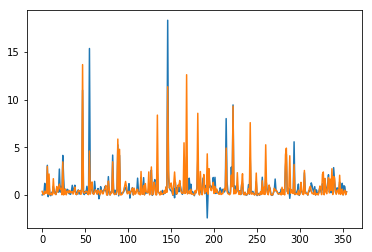

In [62]:
%matplotlib inline



plt.plot(predictions)
plt.plot(actuals)



In [63]:
test_data.head()

,Platform,Year_of_Release,Genre,Publisher,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
4944,3,2014.0,2,5,0.39,72.0,8.0,5.8,32.0,9,3
11652,0,2009.0,0,63,0.08,28.0,5.0,7.9,60.0,661,2
12956,4,2011.0,8,5,0.05,60.0,13.0,7.1,114.0,704,2
4710,4,2007.0,5,2,0.41,96.0,44.0,8.5,3606.0,81,1
8167,0,2010.0,0,5,0.18,59.0,6.0,3,60.0,33,3


In [64]:
test_data.to_csv('/tmp/test_data-no-predictions.csv')

In [87]:
# Add a predictions column to the test_data set
test_data['Predictions'] = pd.Series(predictions, index=test_data.index)

In [89]:
test_data.to_csv('test_data-with-predictions.csv')